In [29]:
!pip install transformers datasets==3.6.0 evaluate accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import torch
import evaluate
import numpy as np
import pandas as pd
from datasets import Dataset, Features, Sequence, Value, load_dataset, concatenate_datasets
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, DefaultDataCollator, TrainingArguments, Trainer, pipeline

import collections
from itertools import chain
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

# Fine-tuning

## Setup

In [ ]:
# загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-multilingual-cased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
# в squad v2 есть примеры вопросов без ответов,
# их нужно будет убрать
def has_answer(example):
    return len(example["answers"]["text"]) > 0

In [ ]:
# функция для предобработки примеров в обучающей выборке
def preprocess_training_examples(examples, max_length=384, stride=128):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # находим начало и конец контекста
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # назначаем лейбл (0, 0), если ответ не попал полностью внутрь контекста
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # иначе лейбл (start position, end position)
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
# функция для предобработки примеров в валидационной выборке
def preprocess_validation_examples(examples, max_length=384, stride=128):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
# загрузка про collator
data_collator = DefaultDataCollator()

In [ ]:
# загрузка метрик для подсчёта на squad
metric = evaluate.load("squad")

In [ ]:
# функция для подсчёта метрик EM и F1
def compute_metrics(
    start_logits,
    end_logits,
    features, examples,
    n_best=20,
    max_answer_length=30
    ):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # проход по всем признакам, относящихся к примеру
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # отбрасываем предсказания, где начало или конец ответа
                    # попадает не в контекст, а в вопрос или спецтокены
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # оставляем только ответы подходящей длины
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # выбираем ответ с максимальной суммой логитов
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

## Zero-shot fine-tuning

_Для дообучения используется датасет SQuAD ver2_

In [ ]:
squad_en = load_dataset("squad_v2")
squad_en = squad_en.filter(has_answer)

README.md: 0.00B [00:00, ?B/s]

squad_v2/train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

squad_v2/validation-00000-of-00001.parqu(…):   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Filter:   0%|          | 0/130319 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11873 [00:00<?, ? examples/s]

### Grid Search

In [ ]:
squad_en_train = squad_en["train"].shuffle(seed=42).select(range(5000))
squad_en_val = squad_en["validation"].shuffle(seed=42).select(range(1000))

In [ ]:
tokenized_squad_en_train = squad_en_train.map(preprocess_training_examples, batched=True, remove_columns=squad_en_train.column_names)
tokenized_squad_en_val = squad_en_val.map(preprocess_validation_examples, batched=True, remove_columns=squad_en_val.column_names)

In [ ]:
learning_rates = [2e-5, 3e-5]
batch_sizes = [16, 32]

results = []

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Training with lr={lr}, batch_size={bs}")

        model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-multilingual-cased")

        training_args = TrainingArguments(
            num_train_epochs=2,
            learning_rate=lr,
            per_device_train_batch_size=bs,
            per_device_eval_batch_size=bs,
            weight_decay=0.01,
            eval_strategy="epoch",
            logging_strategy="epoch",
            save_strategy="no",
            fp16=True,
            report_to="none",
            seed=42,
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_squad_en_train,
            eval_dataset=tokenized_squad_en_val,
            processing_class=tokenizer,
            data_collator=data_collator,
        )

        trainer.train()

        predictions, _, _ = trainer.predict(tokenized_squad_en_val)
        start_logits, end_logits = predictions
        metrics = compute_metrics(start_logits, end_logits, tokenized_squad_en_val, squad_en_val)

        results.append({
            "lr": lr,
            "batch_size": bs,
            "EM": metrics.get("exact_match", None),
            "F1": metrics.get("f1", None)
        })

Training with lr=2e-05, batch_size=16


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,3.431300,No log
2,2.280300,No log


100%|██████████| 1000/1000 [00:02<00:00, 427.80it/s]


Training with lr=2e-05, batch_size=32


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,3.632500,No log
2,2.435000,No log


100%|██████████| 1000/1000 [00:01<00:00, 682.43it/s]


Training with lr=3e-05, batch_size=16


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,3.047200,No log
2,1.786400,No log


100%|██████████| 1000/1000 [00:01<00:00, 679.13it/s]


Training with lr=3e-05, batch_size=32


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,3.351500,No log
2,2.130200,No log


100%|██████████| 1000/1000 [00:02<00:00, 464.78it/s]


In [ ]:
df = pd.DataFrame(results)
print(df)

        lr  batch_size    EM         F1
0  0.00002          16  38.8  49.905857
1  0.00002          32  35.7  47.123923
2  0.00003          16  51.6  63.357910
3  0.00003          32  43.5  55.322922


### Fine-tuning with the best hyperparameters

In [ ]:
squad_en_train = squad_en["train"].shuffle(seed=42).select(range(20000))
squad_en_val = squad_en["validation"].shuffle(seed=42).select(range(5000))

In [ ]:
tokenized_squad_en_train = squad_en_train.map(preprocess_training_examples, batched=True, remove_columns=squad_en_train.column_names)
tokenized_squad_en_val = squad_en_val.map(preprocess_validation_examples, batched=True, remove_columns=squad_en_val.column_names)

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-multilingual-cased")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    num_train_epochs=3,
    learning_rate=3e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    fp16=True,
    report_to="none",
    seed=42,
        )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad_en_train,
    eval_dataset=tokenized_squad_en_val,
    processing_class=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,2.052700,No log
2,1.184700,No log
3,0.831000,No log


TrainOutput(global_step=3804, training_loss=1.3561778745440654, metrics={'train_runtime': 695.3922, 'train_samples_per_second': 87.52, 'train_steps_per_second': 5.47, 'total_flos': 5963758740785664.0, 'train_loss': 1.3561778745440654, 'epoch': 3.0})

In [ ]:
predictions, _, _ = trainer.predict(tokenized_squad_en_val)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, tokenized_squad_en_val, squad_en_val)

100%|██████████| 5000/5000 [00:08<00:00, 575.32it/s]


{'exact_match': 67.62, 'f1': 77.86563568001996}

In [ ]:
model.save_pretrained("/content/drive/MyDrive/models/squad_en_ft")
tokenizer.save_pretrained("/content/drive/MyDrive/models/squad_en_ft")

('/content/drive/MyDrive/models/squad_en_ft/tokenizer_config.json',
 '/content/drive/MyDrive/models/squad_en_ft/special_tokens_map.json',
 '/content/drive/MyDrive/models/squad_en_ft/vocab.txt',
 '/content/drive/MyDrive/models/squad_en_ft/added_tokens.json',
 '/content/drive/MyDrive/models/squad_en_ft/tokenizer.json')

## Translate-test fine-tuning

_Для дообучения используется автоматически переведённый на испанский SQuAD ver2_

In [ ]:
squad_es = load_dataset("squad_es", "v1.1.0", trust_remote_code=True)
squad_es = squad_es.filter(has_answer)

README.md: 0.00B [00:00, ?B/s]

squad_es.py: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/87595 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Filter:   0%|          | 0/87595 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10570 [00:00<?, ? examples/s]

### Grid Search

In [ ]:
squad_es_train = squad_es["train"].shuffle(seed=42).select(range(5000))
squad_es_val = squad_es["validation"].shuffle(seed=42).select(range(1000))

In [ ]:
tokenized_squad_es_train = squad_es_train.map(preprocess_training_examples, batched=True, remove_columns=squad_es_train.column_names)
tokenized_squad_es_val = squad_es_val.map(preprocess_validation_examples, batched=True, remove_columns=squad_es_val.column_names)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
learning_rates = [2e-5, 3e-5]
batch_sizes = [16, 32]

results = []

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Training with lr={lr}, batch_size={bs}")

        model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-multilingual-cased")

        training_args = TrainingArguments(
            num_train_epochs=2,
            learning_rate=lr,
            per_device_train_batch_size=bs,
            per_device_eval_batch_size=bs,
            weight_decay=0.01,
            eval_strategy="epoch",
            logging_strategy="epoch",
            save_strategy="no",
            fp16=True,
            report_to="none",
            seed=42,
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_squad_es_train,
            eval_dataset=tokenized_squad_es_val,
            processing_class=tokenizer,
            data_collator=data_collator,
        )

        trainer.train()

        predictions, _, _ = trainer.predict(tokenized_squad_es_val)
        start_logits, end_logits = predictions
        metrics = compute_metrics(start_logits, end_logits, tokenized_squad_es_val, squad_es_val)

        results.append({
            "lr": lr,
            "batch_size": bs,
            "EM": metrics.get("exact_match", None),
            "F1": metrics.get("f1", None)
        })

Training with lr=2e-05, batch_size=16


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,3.771500,No log
2,2.782500,No log


100%|██████████| 1000/1000 [00:05<00:00, 167.50it/s]


Training with lr=2e-05, batch_size=32


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,3.983800,No log
2,2.952200,No log


100%|██████████| 1000/1000 [00:01<00:00, 653.53it/s]


Training with lr=3e-05, batch_size=16


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,3.449900,No log
2,2.406400,No log


100%|██████████| 1000/1000 [00:01<00:00, 645.54it/s]


Training with lr=3e-05, batch_size=32


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,3.728800,No log
2,2.700200,No log


100%|██████████| 1000/1000 [00:01<00:00, 531.22it/s]


In [ ]:
df = pd.DataFrame(results)
print(df)

        lr  batch_size    EM         F1
0  0.00002          16  27.2  43.077243
1  0.00002          32  25.8  42.061267
2  0.00003          16  34.2  53.352594
3  0.00003          32  30.1  46.999514


### Fine-tuning with the best hyperparameters

In [ ]:
squad_es_train = squad_es["train"].shuffle(seed=42).select(range(20000))
squad_es_val = squad_es["validation"].shuffle(seed=42).select(range(5000))

In [ ]:
tokenized_squad_es_train = squad_es_train.map(preprocess_training_examples, batched=True, remove_columns=squad_es_train.column_names)
tokenized_squad_es_val = squad_es_val.map(preprocess_validation_examples, batched=True, remove_columns=squad_es_val.column_names)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-multilingual-cased")

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    num_train_epochs=3,
    learning_rate=3e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    fp16=True,
    report_to="none",
    seed=42,
        )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad_es_train,
    eval_dataset=tokenized_squad_es_val,
    processing_class=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,2.663500,No log
2,1.791700,No log
3,1.390300,No log


TrainOutput(global_step=3849, training_loss=1.9485130319969473, metrics={'train_runtime': 711.7298, 'train_samples_per_second': 86.464, 'train_steps_per_second': 5.408, 'total_flos': 6030195842151936.0, 'train_loss': 1.9485130319969473, 'epoch': 3.0})

In [ ]:
predictions, _, _ = trainer.predict(tokenized_squad_es_val)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, tokenized_squad_es_val, squad_es_val)

100%|██████████| 5000/5000 [00:09<00:00, 546.81it/s]


{'exact_match': 47.84, 'f1': 65.37697272941077}

In [ ]:
model.save_pretrained("/content/drive/MyDrive/models/squad_es_ft")
tokenizer.save_pretrained("/content/drive/MyDrive/models/squad_es_ft")

('/content/drive/MyDrive/models/squad_es_ft/tokenizer_config.json',
 '/content/drive/MyDrive/models/squad_es_ft/special_tokens_map.json',
 '/content/drive/MyDrive/models/squad_es_ft/vocab.txt',
 '/content/drive/MyDrive/models/squad_es_ft/added_tokens.json',
 '/content/drive/MyDrive/models/squad_es_ft/tokenizer.json')

## Mixed-language fine-tuning

_Для дообучения используются датасеты SQuAD ver2 и SQAC_

In [ ]:
# загружаем испанский датасет
sqac = load_dataset(
    "json",
    data_files={
        "train": "/content/drive/MyDrive/datasets/sqac/train.json",
        "validation": "/content/drive/MyDrive/datasets/sqac/dev.json"
    },
    field="data"
)

In [ ]:
# функция для приведения json-файлов к нужному формату
def flatten_paragraphs(example):
    flat_examples = []
    for paragraph in example["paragraphs"]:
        context = paragraph["context"]
        for qa in paragraph["qas"]:
            flat_examples.append({
                "id": qa["id"],
                "question": qa["question"],
                "context": context,
                "answers": {
                    "text": [a["text"] for a in qa["answers"]],
                    "answer_start": [a["answer_start"] for a in qa["answers"]],
                }
            })
    return flat_examples

In [ ]:
# распаковываем весь датасет
flat_train = list(chain.from_iterable(flatten_paragraphs(ex) for ex in sqac["train"]))
flat_val = list(chain.from_iterable(flatten_paragraphs(ex) for ex in sqac["validation"]))

In [ ]:
# редактируем признаки, чтобы совпадало с squad
features = Features({
    "id": Value("string"),
    "context": Value("string"),
    "question": Value("string"),
    "answers": Sequence({
        "text": Value("string"),
        "answer_start": Value("int32"),
    })
})

In [ ]:
flat_train = Dataset.from_list(flat_train).cast(features)
flat_val = Dataset.from_list(flat_val).cast(features)

Casting the dataset:   0%|          | 0/15036 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1864 [00:00<?, ? examples/s]

### Grid Search

In [ ]:
train_en = squad_en["train"].shuffle(seed=42).select(range(4000))
train_es = flat_train.shuffle(seed=42).select(range(4000))

val_en = squad_en["validation"].shuffle(seed=42).select(range(800))
val_es = flat_val.shuffle(seed=42).select(range(800))

In [ ]:
mixed_train = concatenate_datasets([train_en, train_es]).shuffle(seed=42)
mixed_val = concatenate_datasets([val_en, val_es]).shuffle(seed=42)

In [ ]:
tokenized_mixed_train = mixed_train.map(preprocess_training_examples, batched=True, remove_columns=mixed_train.column_names)
tokenized_mixed_val = mixed_val.map(preprocess_validation_examples, batched=True, remove_columns=mixed_val.column_names)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [ ]:
learning_rates = [2e-5, 3e-5]
batch_sizes = [16, 32]

results = []

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Training with lr={lr}, batch_size={bs}")

        model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-multilingual-cased")

        training_args = TrainingArguments(
            num_train_epochs=2,
            learning_rate=lr,
            per_device_train_batch_size=bs,
            per_device_eval_batch_size=bs,
            weight_decay=0.01,
            eval_strategy="epoch",
            logging_strategy="epoch",
            save_strategy="no",
            fp16=True,
            report_to="none",
            seed=42,
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_mixed_train,
            eval_dataset=tokenized_mixed_val,
            processing_class=tokenizer,
            data_collator=data_collator,
        )

        trainer.train()

        predictions, _, _ = trainer.predict(tokenized_mixed_val)
        start_logits, end_logits = predictions
        metrics = compute_metrics(start_logits, end_logits, tokenized_mixed_val, mixed_val)

        results.append({
            "lr": lr,
            "batch_size": bs,
            "EM": metrics.get("exact_match", None),
            "F1": metrics.get("f1", None)
        })

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with lr=2e-05, batch_size=16


Epoch,Training Loss,Validation Loss
1,3.006400,No log
2,1.884600,No log


100%|██████████| 1600/1600 [00:06<00:00, 249.00it/s]
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with lr=2e-05, batch_size=32


Epoch,Training Loss,Validation Loss
1,3.295300,No log
2,2.257600,No log


100%|██████████| 1600/1600 [00:02<00:00, 541.33it/s]
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with lr=3e-05, batch_size=16


Epoch,Training Loss,Validation Loss
1,2.866800,No log
2,1.652700,No log


100%|██████████| 1600/1600 [00:03<00:00, 514.18it/s]
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with lr=3e-05, batch_size=32


Epoch,Training Loss,Validation Loss
1,3.088400,No log
2,1.909000,No log


100%|██████████| 1600/1600 [00:03<00:00, 526.60it/s]


In [ ]:
df = pd.DataFrame(results)
print(df)

        lr  batch_size       EM         F1
0  0.00002          16  41.1875  55.823478
1  0.00002          32  30.7500  44.714650
2  0.00003          16  44.3125  59.538754
3  0.00003          32  40.2500  55.744771


### Fine-tuning with the best hyperparameters

In [ ]:
train_en = squad_en["train"].shuffle(seed=42).select(range(15000))
train_es = flat_train.shuffle(seed=42).select(range(15000))

val_en = squad_en["validation"].shuffle(seed=42).select(range(1864))
val_es = flat_val.shuffle(seed=42).select(range(1864))

In [ ]:
mixed_train = concatenate_datasets([train_en, train_es]).shuffle(seed=42)
mixed_val = concatenate_datasets([val_en, val_es]).shuffle(seed=42)

In [ ]:
tokenized_mixed_train = mixed_train.map(preprocess_training_examples, batched=True, remove_columns=mixed_train.column_names)
tokenized_mixed_val = mixed_val.map(preprocess_validation_examples, batched=True, remove_columns=mixed_val.column_names)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3728 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-multilingual-cased")

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    num_train_epochs=3,
    learning_rate=3e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    fp16=True,
    report_to="none",
    seed=42,
        )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_mixed_train,
    eval_dataset=tokenized_mixed_val,
    processing_class=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,1.907600,No log
2,1.075100,No log
3,0.727700,No log


TrainOutput(global_step=6777, training_loss=1.2368283484983675, metrics={'train_runtime': 1288.7435, 'train_samples_per_second': 84.117, 'train_steps_per_second': 5.259, 'total_flos': 1.062258698172672e+16, 'train_loss': 1.2368283484983675, 'epoch': 3.0})

In [ ]:
predictions, _, _ = trainer.predict(tokenized_mixed_val)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, tokenized_mixed_val, mixed_val)

100%|██████████| 3728/3728 [00:08<00:00, 451.05it/s]


{'exact_match': 59.76394849785408, 'f1': 73.96611608218134}

In [ ]:
model.save_pretrained("/content/drive/MyDrive/models/squad_en_es_ft")
tokenizer.save_pretrained("/content/drive/MyDrive/models/squad_en_es_ft")

('/content/drive/MyDrive/models/squad_en_es_ft/tokenizer_config.json',
 '/content/drive/MyDrive/models/squad_en_es_ft/special_tokens_map.json',
 '/content/drive/MyDrive/models/squad_en_es_ft/vocab.txt',
 '/content/drive/MyDrive/models/squad_en_es_ft/added_tokens.json',
 '/content/drive/MyDrive/models/squad_en_es_ft/tokenizer.json')

# Evaluation on test data

_Для теста используется датасет MLQA_

## Setup

In [ ]:
# загружаем дообученные модели и токенизаторы
model_paths = {
    "en": "/content/drive/MyDrive/models/squad_en_ft",
    "es": "/content/drive/MyDrive/models/squad_es_ft",
    "en-es": "/content/drive/MyDrive/models/squad_en_es_ft"
}

models = {}
tokenizers = {}
pipelines = {}

for name, path in model_paths.items():
    models[name] = AutoModelForQuestionAnswering.from_pretrained(path)
    tokenizers[name] = AutoTokenizer.from_pretrained(path)
    pipelines[name] = pipeline("question-answering", model=models[name], tokenizer=tokenizers[name])

The tokenizer you are loading from '/content/drive/MyDrive/models/squad_en_ft' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Device set to use cuda:0
The tokenizer you are loading from '/content/drive/MyDrive/models/squad_es_ft' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Device set to use cuda:0
The tokenizer you are loading from '/content/drive/MyDrive/models/squad_en_es_ft' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This 

In [ ]:
mlqa_splits = {
    "en-en": "mlqa.en.en",
    "es-es": "mlqa.es.es",
    "en-es": "mlqa.en.es",
    "es-en": "mlqa.es.en",
}

datasets_mlqa = {
    name: load_dataset(
        "mlqa",
        config,
        split="test[:5000]",
        trust_remote_code=True
    )
    for name, config in mlqa_splits.items()
}

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

mlqa.py: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/11590 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1148 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5253 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5253 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5253 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
# не забываем про collator
data_collator = DefaultDataCollator()

In [ ]:
# функция для предобработки примеров из тестовой выборки
# (аналогична валидационной)
def preprocess_test_examples(examples, tokenizer, max_length=384, stride=128):
    questions = [q.strip() for q in examples["question"]]

    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offsets = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None
            for k, o in enumerate(offsets)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
# функция для получения предсказаний
def run_inference(model, features, batch_size=32, device="cuda"):
    model.to(device)
    model.eval()

    start_logits = []
    end_logits = []

    for i in tqdm(
        range(0, len(features["input_ids"]), batch_size),
        desc="Inference"
    ):
        batch = {
            k: torch.tensor(v[i:i+batch_size]).to(device)
            for k, v in features.items()
            if k not in ["offset_mapping", "example_id"]
        }

        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(outputs.start_logits.cpu().numpy())
        end_logits.append(outputs.end_logits.cpu().numpy())

    return (
        np.concatenate(start_logits, axis=0),
        np.concatenate(end_logits, axis=0),
    )

In [ ]:
# загрузка метрик для подсчёта на squad
metric = evaluate.load("squad")

In [ ]:
# функция для подсчёта метрик EM и F1
def compute_metrics(
    start_logits,
    end_logits,
    features, examples,
    n_best=20,
    max_answer_length=30
    ):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # проход по всем признакам, относящихся к примеру
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # отбрасываем предсказания, где начало или конец ответа
                    # попадает не в контекст, а в вопрос или спецтокены
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # оставляем только ответы подходящей длины
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # выбираем ответ с максимальной суммой логитов
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
# функция для отбора признаков для evaluation
def build_features(tokenized_dataset):
    features = []
    for i in range(len(tokenized_dataset["input_ids"])):
        features.append({
            "example_id": tokenized_dataset["example_id"][i],
            "offset_mapping": tokenized_dataset["offset_mapping"][i],
        })
    return features

In [ ]:
# функция для подсчёта качества на полученных предсказаниях
def evaluate_test(model, tokenizer, dataset, batch_size=32):
    tokenized = preprocess_test_examples(dataset, tokenizer)
    start_logits, end_logits = run_inference(
        model,
        tokenized,
        batch_size=batch_size
    )

    features = build_features(tokenized)

    return compute_metrics(
        start_logits=start_logits,
        end_logits=end_logits,
        features=features,
        examples=dataset
    )

## English and Spanish data only

In [ ]:
experiment_plan = {
    "en": {
        "datasets": ["en-en", "es-es", "en-es", "es-en"],
    },
    "es": {
        "datasets": ["en-en", "es-es", "en-es", "es-en"],
    },
    "en-es": {
        "datasets": ["en-en", "es-es", "en-es", "es-en"],
    },
}

In [ ]:
results = []

for model_name, config in tqdm(
    experiment_plan.items(),
    desc="Models",
):
    model = models[model_name]
    tokenizer = tokenizers[model_name]

    for ds_name in tqdm(
        config["datasets"],
        desc=f"Datasets for {model_name} model"
    ):
        dataset = datasets_mlqa[ds_name]
        scores = evaluate_test(model, tokenizer, dataset)

        results.append({
            "model": model_name,
            "dataset": ds_name,
            "EM": scores["exact_match"],
            "F1": scores["f1"],
        })

df_results = pd.DataFrame(results)

Models:   0%|          | 0/3 [00:00<?, ?it/s]

Datasets for en model:   0%|          | 0/4 [00:00<?, ?it/s]

Inference:   0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Inference:   0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Inference:   0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Inference:   0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Datasets for es model:   0%|          | 0/4 [00:00<?, ?it/s]

Inference:   0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Inference:   0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Inference:   0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Inference:   0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Datasets for en-es model:   0%|          | 0/4 [00:00<?, ?it/s]

Inference:   0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Inference:   0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Inference:   0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Inference:   0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
df_results

,model,dataset,EM,F1
0,en,en-en,53.40,67.914190
1,en,es-es,26.46,46.913214
2,en,en-es,24.86,37.480681
3,en,es-en,31.50,50.329573
4,es,en-en,37.82,53.711140
5,es,es-es,34.28,56.302202
6,es,en-es,34.38,46.828633
7,es,es-en,19.14,36.359397
8,en-es,en-en,54.76,69.340377
9,en-es,es-es,34.96,59.249781


In [ ]:
df_results.to_csv("mlqa_results.csv", index=False)

## German data

In [ ]:
datasets_mlqa_de = {
    "de-de": load_dataset("mlqa", "mlqa.de.de", split="test[:5000]"),
    "de-en": load_dataset("mlqa", "mlqa.de.en", split="test[:5000]"),
    "de-es": load_dataset("mlqa", "mlqa.de.es", split="test[:5000]"),
    "en-de": load_dataset("mlqa", "mlqa.en.de", split="test[:5000]"),
    "es-de": load_dataset("mlqa", "mlqa.es.de", split="test[:5000]"),
}

Generating test split:   0%|          | 0/4517 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/512 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4517 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/512 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1776 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/196 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4517 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/512 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1776 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/196 [00:00<?, ? examples/s]

In [ ]:
results_de = []

for ds_name, ds in tqdm(datasets_mlqa_de.items(), desc="German datasets"):
    # токенизация и подготовка features
    tokenized = tokenizer(
        [q.strip() for q in ds["question"]],
        ds["context"],
        max_length=384,
        truncation="only_second",
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = tokenized.pop("overflow_to_sample_mapping")
    example_ids = []
    for i in range(len(tokenized["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(ds["id"][sample_idx])

        sequence_ids = tokenized.sequence_ids(i)
        offsets = tokenized["offset_mapping"][i]
        tokenized["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offsets)
        ]
    tokenized["example_id"] = example_ids

    features = build_features(tokenized)

    # инференс
    start_logits, end_logits = run_inference(models["en-es"], tokenized, batch_size=32)

    # вычисление метрик
    scores = compute_metrics(start_logits, end_logits, features, ds)

    results_de.append({
        "model": "en-es",
        "dataset": ds_name,
        "EM": scores["exact_match"],
        "F1": scores["f1"],
    })

df_results_de = pd.DataFrame(results_de)

German datasets:   0%|          | 0/5 [00:00<?, ?it/s]

Inference:   0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/4517 [00:00<?, ?it/s]

Inference:   0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/4517 [00:00<?, ?it/s]

Inference:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/1776 [00:00<?, ?it/s]

Inference:   0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/4517 [00:00<?, ?it/s]

Inference:   0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/1776 [00:00<?, ?it/s]

In [ ]:
df_results_de

,model,dataset,EM,F1
0,en-es,de-de,28.691609,45.805629
1,en-es,de-en,31.680319,47.150899
2,en-es,de-es,30.349099,44.992105
3,en-es,en-de,29.090104,41.447918
4,en-es,es-de,20.833333,38.750763


In [ ]:
df_results_de.to_csv("mlqa_results_de.csv", index=False)

# Results visualization

In [13]:
df_results = pd.read_csv('mlqa_results.csv')
df_results_de = pd.read_csv('mlqa_results_de.csv')

In [14]:
model_to_setting = {
    "en": "zero-shot",
    "es": "translate-train",
    "en-es": "mixed"
}

df_results["setting"] = df_results["model"].map(model_to_setting)

## Methods x datasets (English & Spanish)

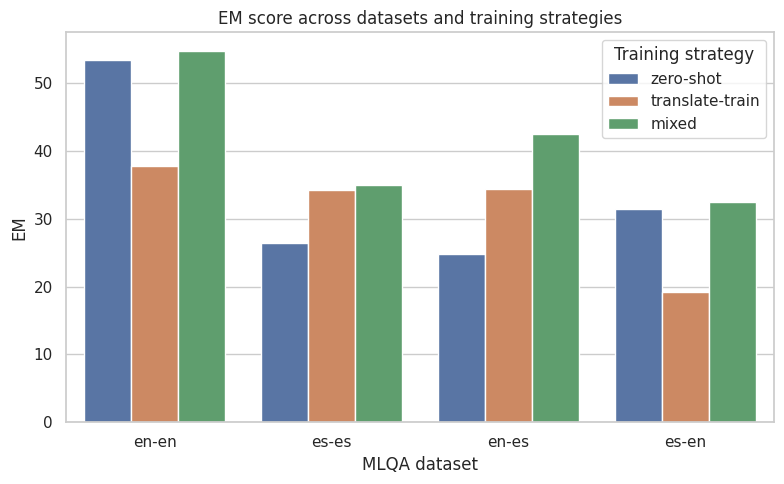

In [26]:
plt.figure(figsize=(8, 5))

sns.barplot(
    data=df_results,
    x="dataset",
    y="EM",
    hue="setting",
)

plt.title("EM score across datasets and training strategies")
plt.ylabel("EM")
plt.xlabel("MLQA dataset")
plt.legend(title="Training strategy")
plt.tight_layout()
plt.show()

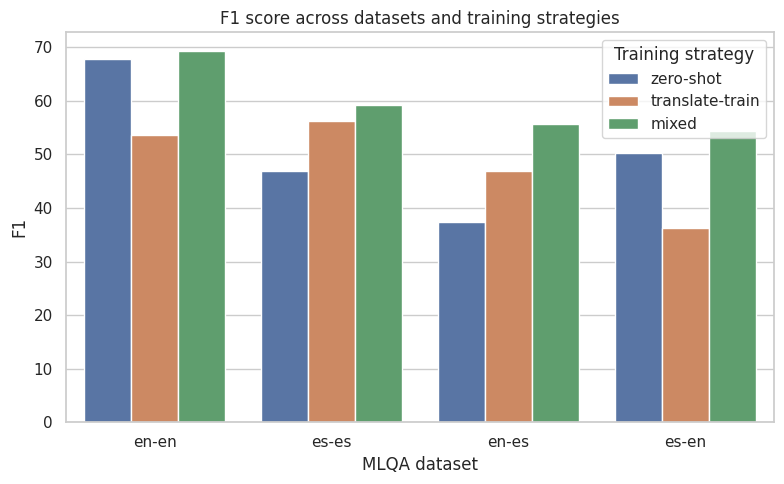

In [27]:
plt.figure(figsize=(8, 5))

sns.barplot(
    data=df_results,
    x="dataset",
    y="F1",
    hue="setting",
)

plt.title("F1 score across datasets and training strategies")
plt.ylabel("F1")
plt.xlabel("MLQA dataset")
plt.legend(title="Training strategy")
plt.tight_layout()
plt.show()

## Zero-shot vs Translate-train (Spanish only)

In [18]:
es_datasets = ["es-es", "en-es", "es-en"]

df_es_compare = df_results[
    (df_results["model"].isin(["en", "es"])) &
    (df_results["dataset"].isin(es_datasets))
]

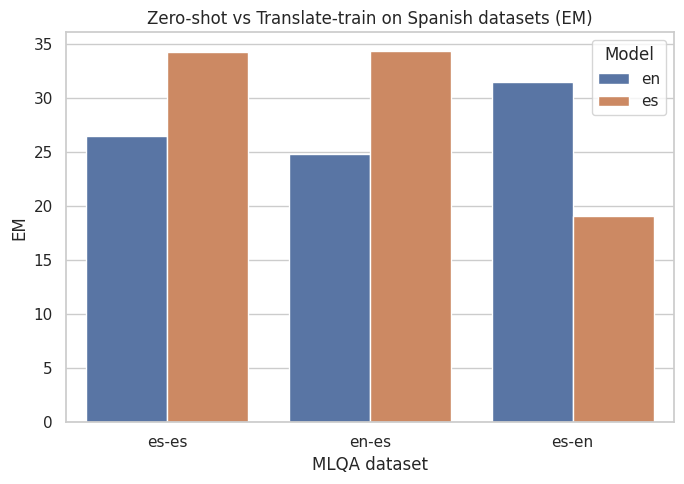

In [34]:
plt.figure(figsize=(7, 5))

sns.barplot(
    data=df_es_compare,
    x="dataset",
    y="EM",
    hue="model",
)

plt.title("Zero-shot vs Translate-train on Spanish datasets (EM)")
plt.ylabel("EM")
plt.xlabel("MLQA dataset")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

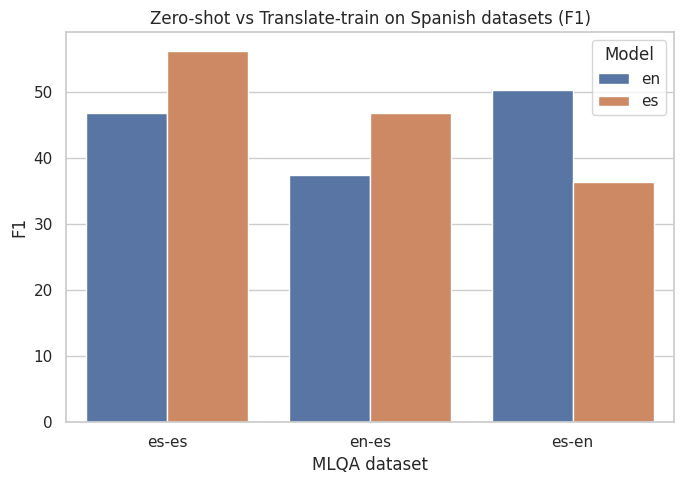

In [35]:
plt.figure(figsize=(7, 5))

sns.barplot(
    data=df_es_compare,
    x="dataset",
    y="F1",
    hue="model",
)

plt.title("Zero-shot vs Translate-train on Spanish datasets (F1)")
plt.ylabel("F1")
plt.xlabel("MLQA dataset")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

## Single-language vs mixed fine-tuning (English & Spanish)

In [21]:
df_mixed_compare = df_results[
    df_results["dataset"].isin(["en-en", "es-es", "en-es", "es-en"])
]

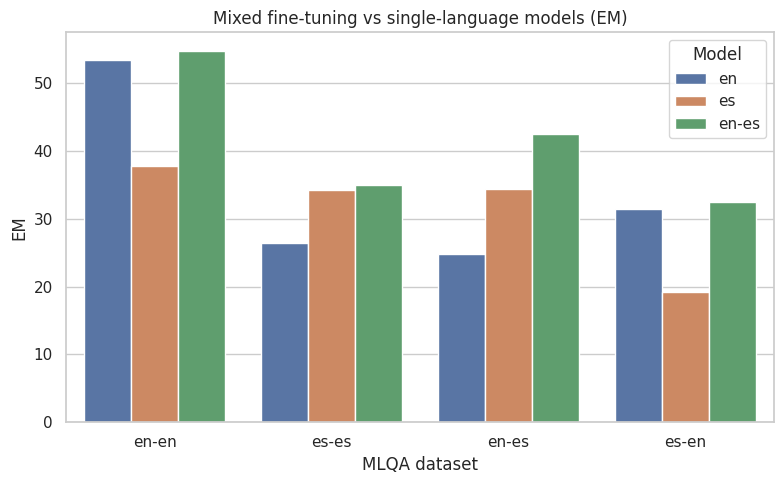

In [36]:
plt.figure(figsize=(8, 5))

sns.barplot(
    data=df_mixed_compare,
    x="dataset",
    y="EM",
    hue="model",
)

plt.title("Mixed fine-tuning vs single-language models (EM)")
plt.ylabel("EM")
plt.xlabel("MLQA dataset")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

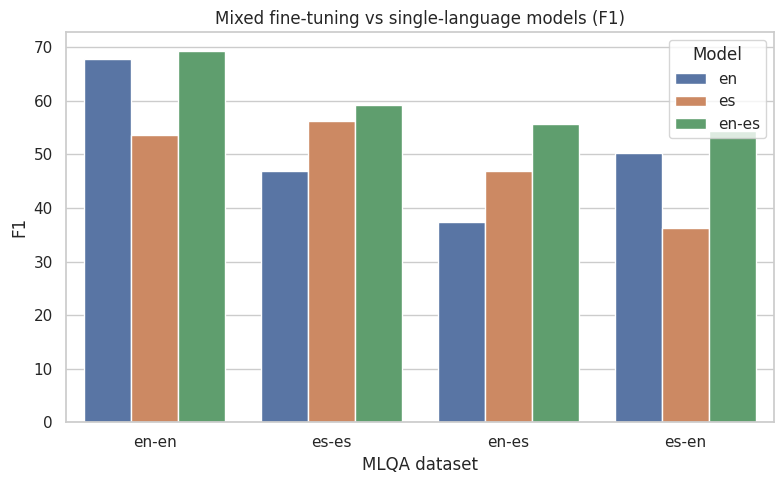

In [37]:
plt.figure(figsize=(8, 5))

sns.barplot(
    data=df_mixed_compare,
    x="dataset",
    y="F1",
    hue="model",
)

plt.title("Mixed fine-tuning vs single-language models (F1)")
plt.ylabel("F1")
plt.xlabel("MLQA dataset")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

## German zero-shot with a mixed model

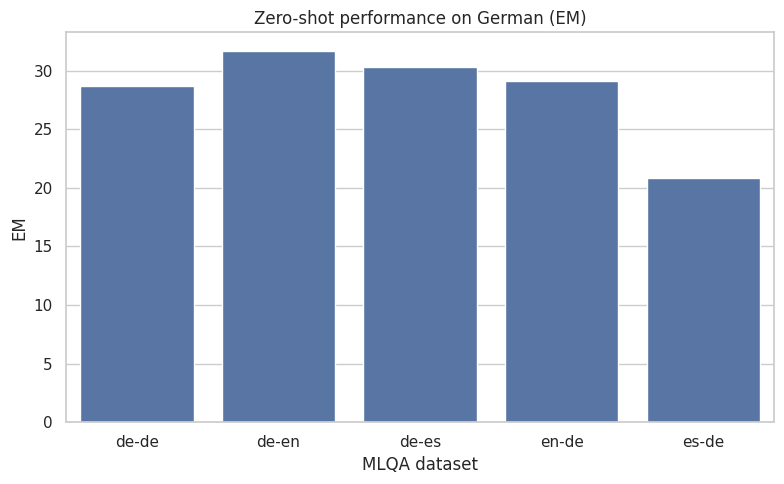

In [38]:
plt.figure(figsize=(8, 5))

sns.barplot(
    data=df_results_de,
    x="dataset",
    y="EM",
)

plt.title("Zero-shot performance on German (EM)")
plt.ylabel("EM")
plt.xlabel("MLQA dataset")
plt.tight_layout()
plt.show()

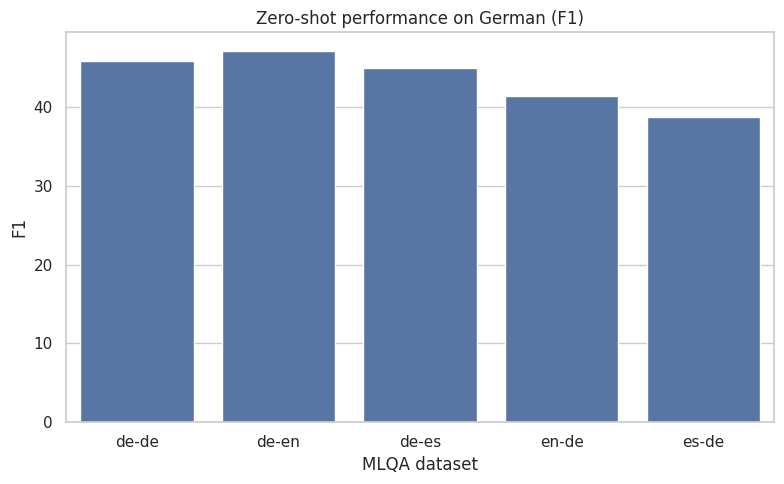

In [39]:
plt.figure(figsize=(8, 5))

sns.barplot(
    data=df_results_de,
    x="dataset",
    y="F1",
)

plt.title("Zero-shot performance on German (F1)")
plt.ylabel("F1")
plt.xlabel("MLQA dataset")
plt.tight_layout()
plt.show()